In [18]:
# ! pip install optuna optuna-integration[xgboost]

In [19]:
# !pip list | grep optuna

In [20]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [21]:
import pandas as pd
import numpy as np
import optuna
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import root_mean_squared_error
import joblib
import os
import torch

# Set random seed for reproducibility
np.random.seed(42)

# Load the data
path_train = "./data/project_train.csv"
df = pd.read_csv(path_train, index_col=0)

# Separate features and target
X = df.drop("TARGET", axis=1)
y = df["TARGET"]


n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)
train_valid_splits = list(tscv.split(X))


gpu_available = torch.cuda.is_available()
print(f"GPU Available: {gpu_available}")


def threshold_sum(y_true, y_pred, threshold):
    """
    Calculate the sum of targets for which the model predictions are above the threshold.
    Targets where predictions are below the threshold are set to zero.

    Args:
        y_true (array-like): The true target values.
        y_pred (array-like): The predicted target values.
        threshold (float): The threshold value to filter predictions.

    Returns:
        float: The sum of target values where predictions exceed the threshold.
    """
    adjusted_target = np.where(y_pred > threshold, y_true, 0)
    return np.sum(adjusted_target)


# Define the objective function for Optuna
def objective(trial):
    # Define hyperparameters to optimize
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 10, 500),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-4, 1.0, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-4, 1.0, log=True),
        "early_stopping_rounds": 10,
    }

    threshold = 0.0

    # Use GPU if available
    if gpu_available:
        params["device"] = "cuda"
        params["tree_method"] = "hist"

    scores = []
    custom_metric_values = []

    for train_index, valid_index in train_valid_splits:
        X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]

        model = xgb.XGBRegressor(**params)
        model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=False)

        y_pred = model.predict(X_valid)
        score = root_mean_squared_error(y_valid, y_pred)
        scores.append(score)

        # Calculate custom metric
        custom_metric_value = threshold_sum(y_valid, y_pred, threshold)
        custom_metric_values.append(custom_metric_value)

    # Store the sum of custom metric values in the trial for logging
    total_custom_metric_value = sum(custom_metric_values)
    trial.set_user_attr("sum_custom_metric", total_custom_metric_value)

    return np.mean(scores)


# Create a study object and optimize the objective function
# if gpu available don't paralelize, otherwise paralelize on all cpu cores
study = optuna.create_study(direction="minimize", study_name="xgboost_regressor_optimization")
study.optimize(objective, n_trials=200, n_jobs=1 if gpu_available else -1)

# Print the best parameters and score
print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
params = trial.params
print("  Params: ")
for key, value in params.items():
    print("    {}: {}".format(key, value))

# Save the study
joblib.dump(study, "./studies/xgboost_regressor_optuna_study.pkl")

# Train the final model with the best parameters
best_params = study.best_params
if gpu_available:
    params["device"] = "cuda"
    params["tree_method"] = "hist"


final_model = xgb.XGBRegressor(**best_params)
final_model.fit(X, y)

# Save the final model
final_model.save_model("./models/xgboost_regressor.json")

print("Optimization complete. Study and best model saved.")

[I 2024-10-20 12:05:11,271] A new study created in memory with name: xgboost_regressor_optimization


GPU Available: False


[I 2024-10-20 12:05:20,537] Trial 0 finished with value: 0.007369946593778829 and parameters: {'n_estimators': 309, 'max_depth': 8, 'learning_rate': 0.09924295781733743, 'min_child_weight': 1, 'subsample': 0.7933513933053044, 'colsample_bytree': 0.6441851371521639, 'gamma': 0.15172823400935598, 'reg_alpha': 0.0014201570579343548, 'reg_lambda': 0.4735845313231809}. Best is trial 0 with value: 0.007369946593778829.
[I 2024-10-20 12:05:20,793] Trial 1 finished with value: 0.007369962993646051 and parameters: {'n_estimators': 408, 'max_depth': 9, 'learning_rate': 0.0013432344102142827, 'min_child_weight': 3, 'subsample': 0.6781833461145146, 'colsample_bytree': 0.7846078685611046, 'gamma': 0.5882716596244788, 'reg_alpha': 0.13535712630176905, 'reg_lambda': 0.0002237743747123109}. Best is trial 0 with value: 0.007369946593778829.
[I 2024-10-20 12:05:30,152] Trial 3 finished with value: 0.007369962560117929 and parameters: {'n_estimators': 312, 'max_depth': 3, 'learning_rate': 0.0023428950271

Best trial:
  Value:  0.007336190922924759
  Params: 
    n_estimators: 466
    max_depth: 4
    learning_rate: 0.08262335147259535
    min_child_weight: 4
    subsample: 0.9499571304165573
    colsample_bytree: 0.659952453182535
    gamma: 5.7408524139890456e-05
    reg_alpha: 0.1871535641416443
    reg_lambda: 0.5665994033412384
Optimization complete. Study and best model saved.


<ipython-input-22-55552728ee19>:16: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study)


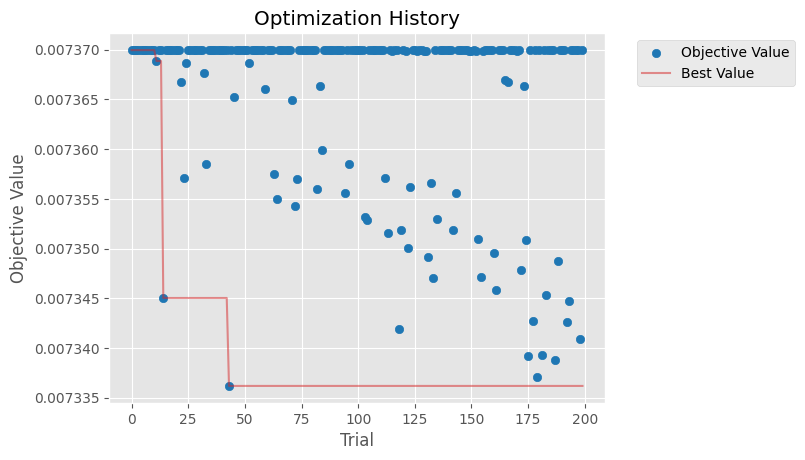

<ipython-input-22-55552728ee19>:22: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_param_importances(study)


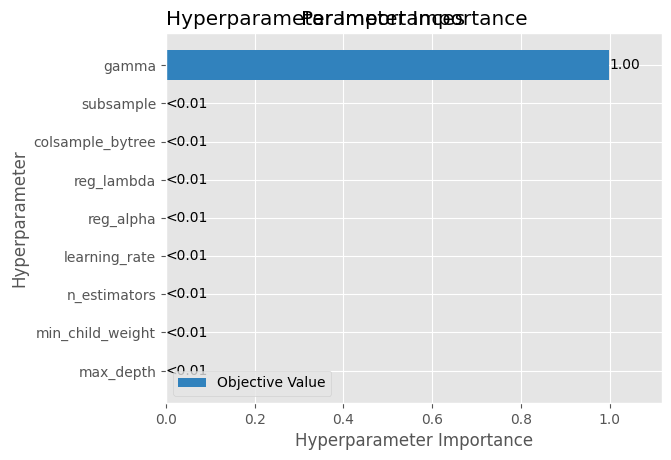

<ipython-input-22-55552728ee19>:28: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_slice(study)


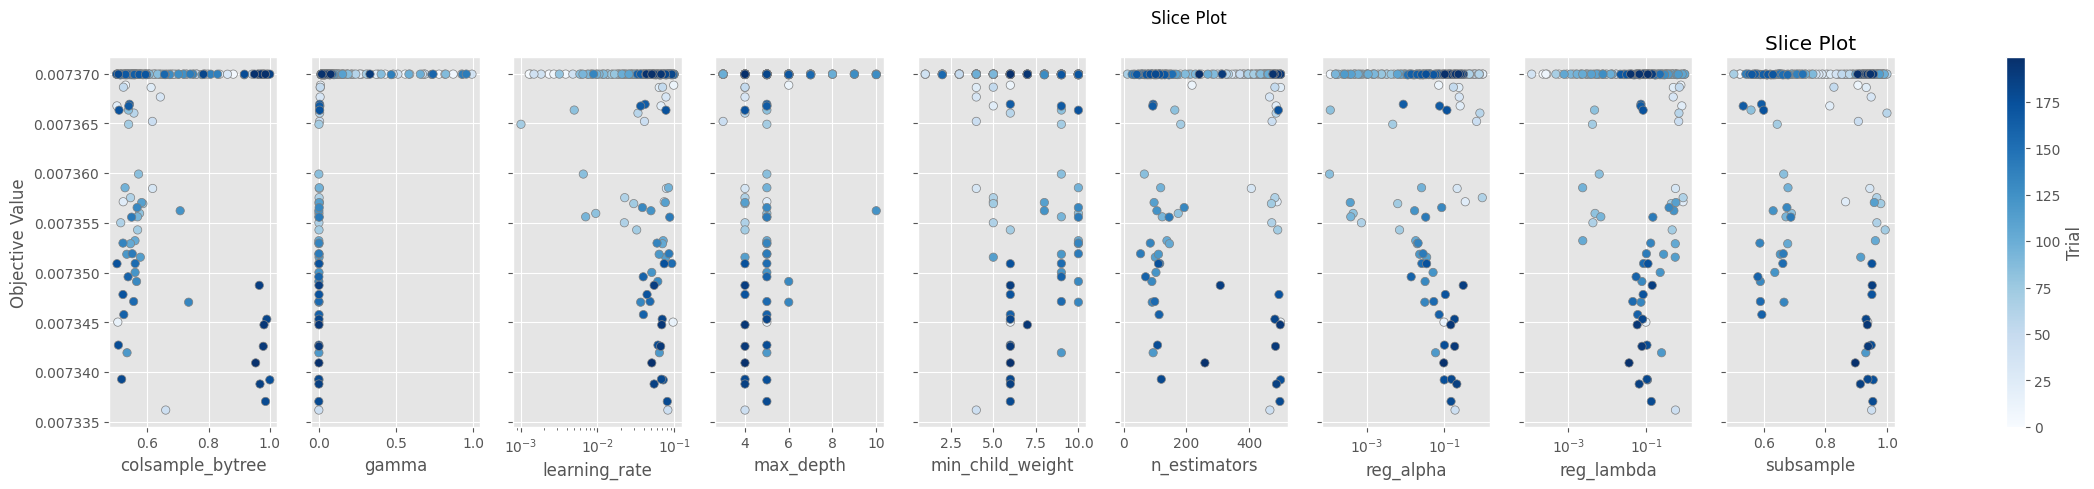

<ipython-input-22-55552728ee19>:34: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_contour(study)
[W 2024-10-20 12:24:06,119] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


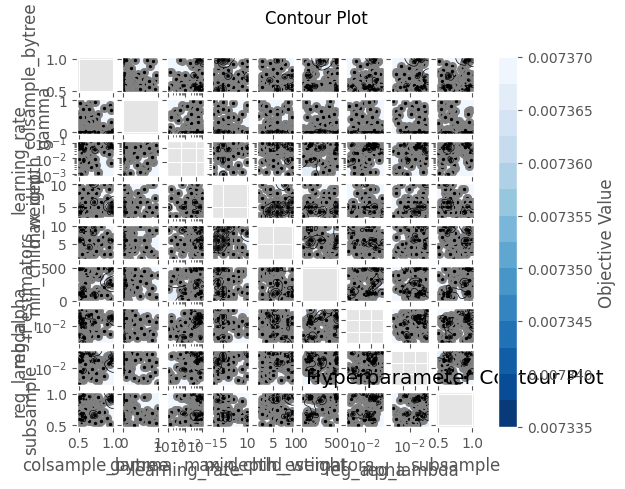

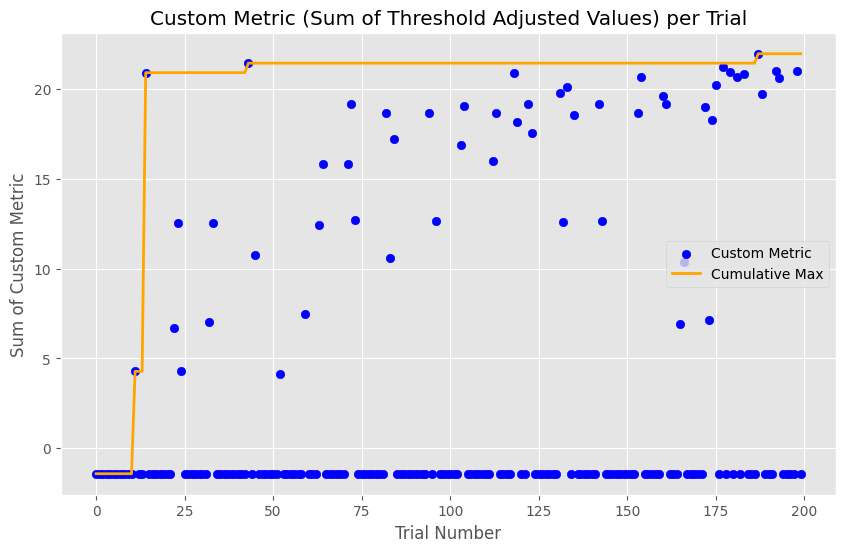

Mean Squared Error (MSE): 4.855782073024844e-05
Mean Absolute Error (MAE): 0.004321439168197682
R-squared (R2): 0.12642961086219917


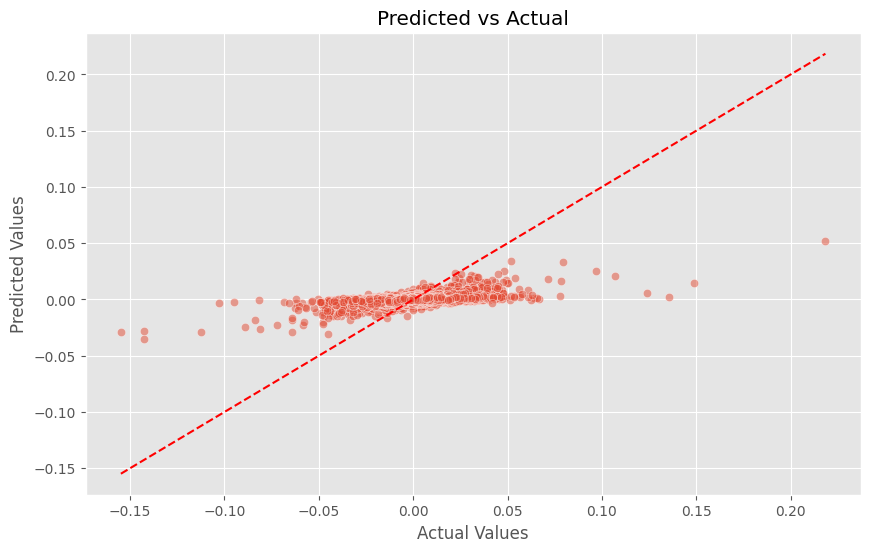

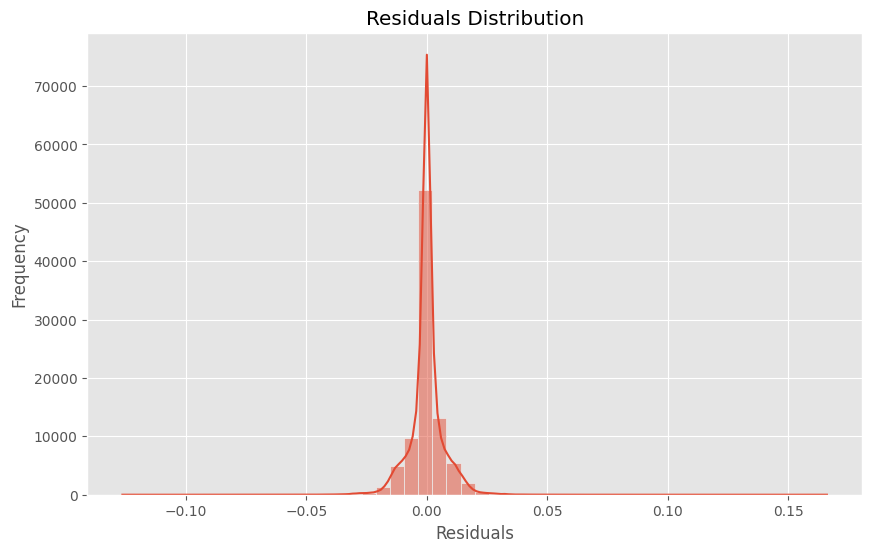

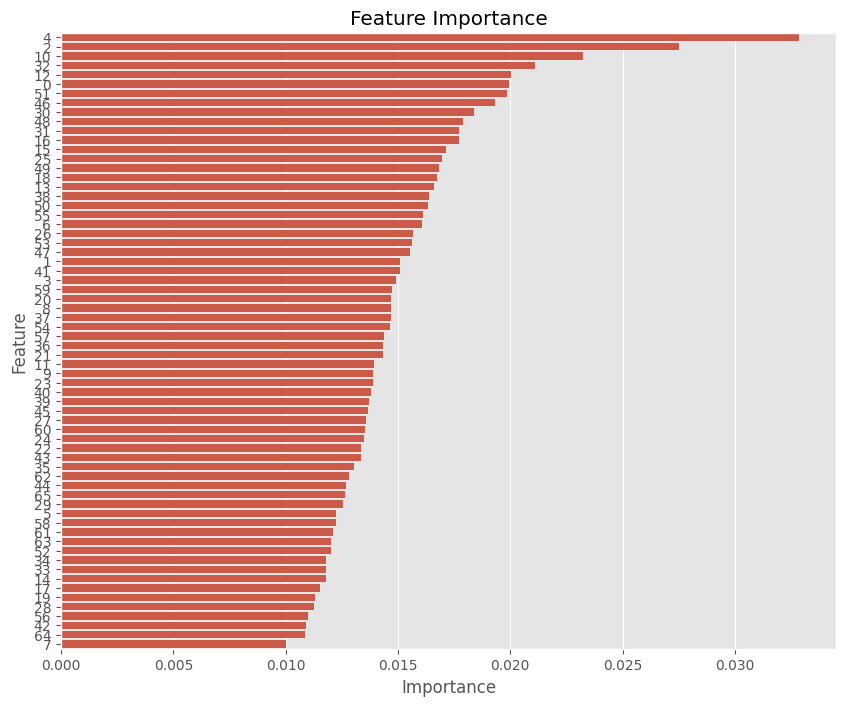


Best Trial Summary:

  Value (Best RMSE): 0.007336190922924759
  Params:
    n_estimators: 466
    max_depth: 4
    learning_rate: 0.08262335147259535
    min_child_weight: 4
    subsample: 0.9499571304165573
    colsample_bytree: 0.659952453182535
    gamma: 5.7408524139890456e-05
    reg_alpha: 0.1871535641416443
    reg_lambda: 0.5665994033412384


In [22]:
import pandas as pd
import numpy as np
import optuna
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import root_mean_squared_error
import joblib
import os
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import optuna.visualization as vis
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Plot the optimization history
optuna.visualization.matplotlib.plot_optimization_history(study)
plt.title("Optimization History")
plt.savefig("./plots/optimization_history.png")
plt.show()

# Plot parameter importance
optuna.visualization.matplotlib.plot_param_importances(study)
plt.title("Parameter Importance")
plt.savefig("./plots/param_importance.png")
plt.show()

# Plot slice plot for detailed analysis
optuna.visualization.matplotlib.plot_slice(study)
plt.title("Slice Plot")
plt.savefig("./plots/slice_plot.png")
plt.show()

# Plot contour plot for interactions between parameters
optuna.visualization.matplotlib.plot_contour(study)
plt.title("Hyperparameter Contour Plot")
plt.savefig("./plots/contour_plot.png")
plt.show()

# Extract custom metric values from the study
custom_metric_values = []
for trial in study.trials:
    custom_metric_values.append(trial.user_attrs["sum_custom_metric"])

cumulative_max = np.maximum.accumulate(custom_metric_values)

# Create the scatter plot and the line for the cumulative max
plt.figure(figsize=(10, 6))
plt.scatter(range(len(custom_metric_values)), custom_metric_values, label="Custom Metric", color="blue")
plt.plot(cumulative_max, label="Cumulative Max", color="orange", linewidth=2)

plt.title("Custom Metric (Sum of Threshold Adjusted Values) per Trial")
plt.xlabel("Trial Number")
plt.ylabel("Sum of Custom Metric")
plt.grid(True)
plt.legend()
plt.show()


# Predictions from the final model
y_pred = final_model.predict(X)

# Calculate evaluation metrics
mse = mean_squared_error(y, y_pred)
mae = mean_absolute_error(y, y_pred)
r2 = r2_score(y, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R2): {r2}")

# Plot predicted vs actual
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y, y=y_pred, alpha=0.5)
plt.plot([min(y), max(y)], [min(y), max(y)], color="red", linestyle="--")  # Line y=x
plt.title("Predicted vs Actual")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.savefig("./plots/predicted_vs_actual.png")
plt.show()

# Plot residuals
residuals = y - y_pred
plt.figure(figsize=(10, 6))
sns.histplot(residuals, bins=50, kde=True)
plt.title("Residuals Distribution")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.savefig("./plots/residuals.png")
plt.show()

# Get feature importance
importance = final_model.feature_importances_
features = X.columns

# Create a DataFrame for feature importance
feature_importance_df = pd.DataFrame({"Feature": features, "Importance": importance}).sort_values(
    by="Importance", ascending=False
)

# Plot feature importance
plt.figure(figsize=(10, 8))
sns.barplot(x="Importance", y="Feature", data=feature_importance_df)
plt.title("Feature Importance")
plt.savefig("./plots/feature_importance.png")
plt.show()


best_trial = study.best_trial

print(f"\nBest Trial Summary:\n")
print(f"  Value (Best RMSE): {best_trial.value}")
print(f"  Params:")
for key, value in best_trial.params.items():
    print(f"    {key}: {value}")

with open("./studies/best_trial_summary.txt", "w") as f:
    f.write(f"Best Trial Value (Best RMSE): {best_trial.value}\n")
    f.write(f"Best Parameters:\n")
    for key, value in best_trial.params.items():
        f.write(f"  {key}: {value}\n")

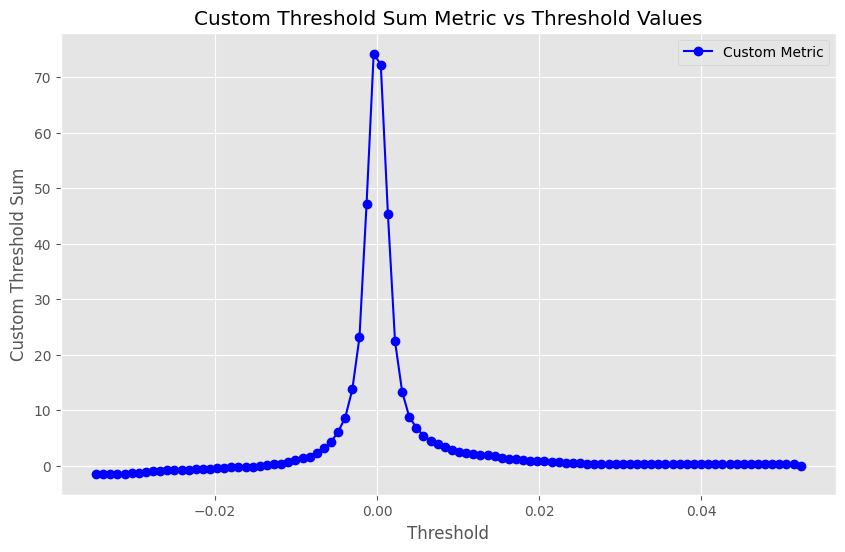

In [23]:
y_pred = final_model.predict(X)

threshold_values = np.linspace(np.min(y_pred), np.max(y_pred), 100)  # 50 values between 0 and max(y_pred)

custom_metric_values = []

for threshold in threshold_values:
    custom_metric_value = threshold_sum(y, y_pred, threshold)
    custom_metric_values.append(custom_metric_value)

# Plot the custom metric vs threshold
plt.figure(figsize=(10, 6))
plt.plot(threshold_values, custom_metric_values, marker="o", color="b", label="Custom Metric")
plt.title("Custom Threshold Sum Metric vs Threshold Values")
plt.xlabel("Threshold")
plt.ylabel("Custom Threshold Sum")
plt.grid(True)
plt.legend()
plt.savefig("./plots/custom_metric_vs_threshold.png")
plt.show()

Custom Threshold Sum (Threshold = 0.0): 77.7740165951


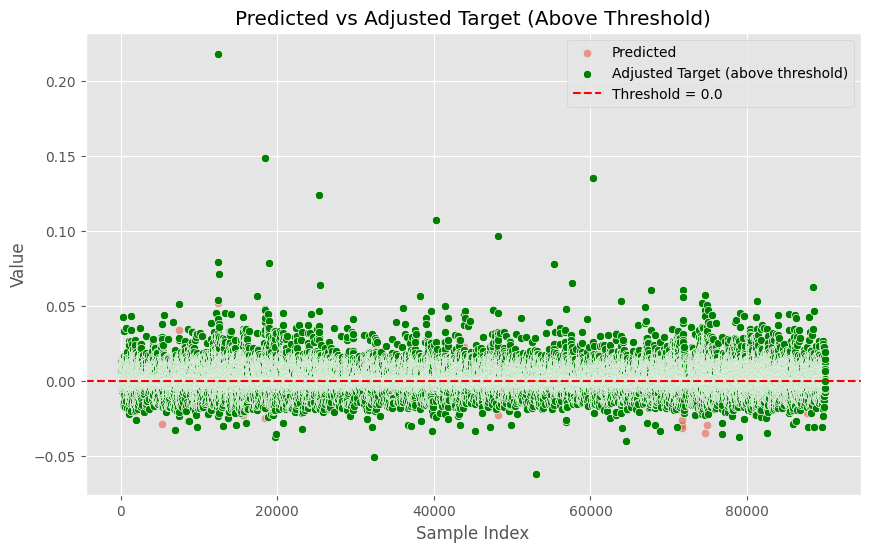

In [24]:
y_pred = final_model.predict(X)

threshold = 0.0

custom_metric_value = threshold_sum(y, y_pred, threshold)
print(f"Custom Threshold Sum (Threshold = {threshold}): {custom_metric_value}")

# Plot predicted vs adjusted target (above threshold)
adjusted_y = np.where(y_pred > threshold, y, 0)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=range(len(y)), y=y_pred, label="Predicted", alpha=0.5)
sns.scatterplot(x=range(len(y)), y=adjusted_y, label="Adjusted Target (above threshold)", color="green")
plt.axhline(threshold, color="red", linestyle="--", label=f"Threshold = {threshold}")
plt.title("Predicted vs Adjusted Target (Above Threshold)")
plt.xlabel("Sample Index")
plt.ylabel("Value")
plt.legend()
plt.savefig("./plots/predicted_vs_adjusted_threshold.png")
plt.show()